# Generating spike trains from a synthetic connectome

In this notebook, we generate spiketrains from a recurrent E-I network with current-based LIF neurons, and assembly connectivity inspired by zebrafish Dp.

### Overview
1. First we generate a biologically plausible recurrent weight matrix with a Dp-inspired assembly structure.
2. Next we generate excitatory mitral cell inputs from the OB with Poisson stastics and sparse projections.
3. Then we initialise our network with parameters adapted from [Meissner-Bernard et al. (2025)](https://doi.org/10.1016/j.celrep.2025.115330).
4. Finally we run our network and examine the output dynamics.

In [39]:
%load_ext autoreload
%autoreload 2
%xmode Verbose

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Exception reporting mode: Verbose


In [40]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
from synthetic_connectome import topology_generators, weight_assigners
from network_simulators.current_lif_network import CurrentLIFNetwork

repo_root = Path().resolve().parent

### Load all network parameters

We first load all parameters from a single CSV file that specifies network topology, synaptic weight distributions, feedforward input configuration, and neuron physiology parameters.

In [41]:
# Load network parameters from CSV
params_df = pd.read_csv(repo_root / "parameters" / "Dp-default.csv", comment="#")

In [42]:
# Load parameters into python variables
params = params_df.set_index('symbol')

delta_t = params.loc['delta_t', 'value']
duration = params.loc['duration', 'value']
num_neurons = int(params.loc['num_neurons', 'value'])
num_assemblies = int(params.loc['num_assemblies', 'value'])
p_within = params.loc['p_within', 'value']
p_between = params.loc['p_between', 'value']
p_E = params.loc['p_E', 'value']
w_mu_E = params.loc['w_mu_E', 'value']
w_sigma_E = params.loc['w_sigma_E', 'value']
w_mu_I = params.loc['w_mu_I', 'value']
w_sigma_I = params.loc['w_sigma_I', 'value']
num_mitral = int(params.loc['num_mitral', 'value'])
r_mitral = params.loc['r_mitral', 'value']
p_feedforward = params.loc['p_feedforward', 'value']
w_mu_FF = params.loc['w_mu_FF', 'value']
w_sigma_FF = params.loc['w_sigma_FF', 'value']
scaling_factor_E = params.loc['scaling_factor_E', 'value']
scaling_factor_I = params.loc['scaling_factor_I', 'value']
scaling_factor_FF = params.loc['scaling_factor_FF', 'value']
tau_mem_E = params.loc['tau_mem_E', 'value']
tau_syn_E = params.loc['tau_syn_E', 'value']
R_E = params.loc['R_E', 'value']
U_rest_E = params.loc['U_rest_E', 'value']
theta_E = params.loc['theta_E', 'value']
U_reset_E = params.loc['U_reset_E', 'value']
tau_ref_E = params.loc['tau_ref_E', 'value']
tau_mem_I = params.loc['tau_mem_I', 'value']
tau_syn_I = params.loc['tau_syn_I', 'value']
R_I = params.loc['R_I', 'value']
U_rest_I = params.loc['U_rest_I', 'value']
theta_I = params.loc['theta_I', 'value']
U_reset_I = params.loc['U_reset_I', 'value']
tau_ref_I = params.loc['tau_ref_I', 'value']

In [43]:
# Display all network parameters
print("All Network Parameters")
print("=" * 22)
display(params_df.style.set_properties(**{'text-align': 'left'}).set_table_styles([
    {'selector': 'th', 'props': [('text-align', 'left')]}
]).hide(axis='index').format({'value': '{:.1f}'}))

All Network Parameters


symbol,unit,description,value
delta_t,ms,Time resolution of the simulation,1.0
duration,ms,Total simulation duration,10000.0
num_neurons,nan,Total number of neurons in the network,50.0
num_assemblies,nan,Number of assemblies in the network,5.0
p_within,nan,Connection probability within assemblies,0.3
p_between,nan,Connection probability between assemblies,0.1
p_E,nan,Proportion of excitatory neurons,0.8
w_mu_E,voxel,Mean (log-space) for excitatory synaptic weights,1.0
w_sigma_E,voxel,Standard deviation (log-space) for excitatory weights,0.2
w_mu_I,voxel,Mean (log-space) for inhibitory synaptic weights,2.4


### Generate Assembly-Based Topology

We now create an unweighted network with assembly-based connectivity structure. This is a matrix indicating inhibitory/excitatory connections.

We then visualise this graph. Note that the assembly structure is not obvious because by design our matrix is shuffled.

In [44]:
# Display network topology parameters
topology_params = params_df[params_df['symbol'].isin(['num_neurons', 'num_assemblies', 'p_within', 'p_between', 'p_E'])]

print("Network Topology Parameters")
print("=" * 62)
display(topology_params.style.set_properties(**{'text-align': 'left'}).set_table_styles([
    {'selector': 'th', 'props': [('text-align', 'left')]}
]).hide(axis='index').format({'value': '{:.1f}'}))

Network Topology Parameters


symbol,unit,description,value
num_neurons,nan,Total number of neurons in the network,50.0
num_assemblies,nan,Number of assemblies in the network,5.0
p_within,nan,Connection probability within assemblies,0.3
p_between,nan,Connection probability between assemblies,0.1
p_E,nan,Proportion of excitatory neurons,0.8


In [45]:
# Generate assembly-based connectivity graph and neuron types
connectivity_graph, neuron_types = topology_generators.assembly_generator(
    num_neurons=num_neurons,
    num_assemblies=num_assemblies,
    p_within=p_within,
    p_between=p_between,
    p_E=p_E,
)

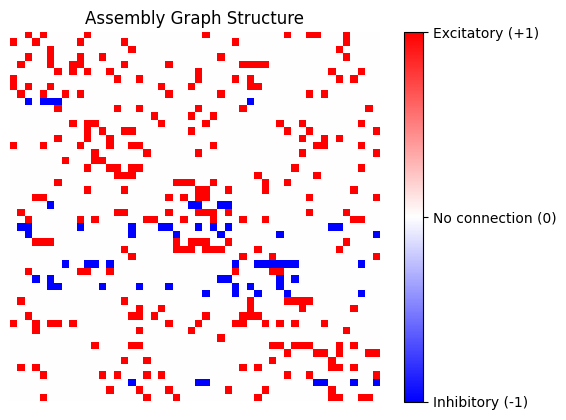

In [46]:
# Visualize assembly graph structure
fig, ax = plt.subplots()
im = ax.imshow(connectivity_graph, cmap="bwr", vmin=-1, vmax=1)
cbar = plt.colorbar(im, ax=ax, ticks=[-1, 0, 1])
cbar.ax.set_yticklabels(["Inhibitory (-1)", "No connection (0)", "Excitatory (+1)"])
ax.set_title("Assembly Graph Structure")
ax.axis("off")
plt.show()

### Assign Synaptic Weights

We now convert the unweighted connectivity graph into a weighted graph, with inhibitory and excitatory synaptic strengths drawn from biologically realistic log-normal distributions.

We want to balance the total synaptic input to each neuron on average. Given that the log-normal distribution has expectation:

$$\mathbb{E}[X] = \exp\left(\mu + \frac{\sigma^2}{2}\right)$$

And we have roughly four times as many excitatory neurons as inhibitory neurons, we can approximately acheive balance by setting:

$$\mu_I = \mu_E + \log{4}$$

We then visualise this graph and check the distribution of input weights to all neurons is roughly balanced.

In [47]:
# Display recurrent synaptic weight parameters
weight_params = params_df[params_df['symbol'].isin(['w_mu_E', 'w_sigma_E', 'w_mu_I', 'w_sigma_I'])]

print("Recurrent Synaptic Weight Parameters")
print("=" * 62)
display(weight_params.style.set_properties(**{'text-align': 'left'}).set_table_styles([
    {'selector': 'th', 'props': [('text-align', 'left')]}
]).hide(axis='index').format({'value': '{:.1f}'}))

Recurrent Synaptic Weight Parameters


symbol,unit,description,value
w_mu_E,voxel,Mean (log-space) for excitatory synaptic weights,1.0
w_sigma_E,voxel,Standard deviation (log-space) for excitatory weights,0.2
w_mu_I,voxel,Mean (log-space) for inhibitory synaptic weights,2.4
w_sigma_I,voxel,Standard deviation (log-space) for inhibitory weights,0.2


In [48]:
# Assign log-normal weights to connectivity graph
weights = weight_assigners.assign_weights_lognormal(
    connectivity_graph=connectivity_graph,
    neuron_types=neuron_types,
    w_mu_E=w_mu_E,
    w_sigma_E=w_sigma_E,
    w_mu_I=w_mu_I,
    w_sigma_I=w_sigma_I,
)

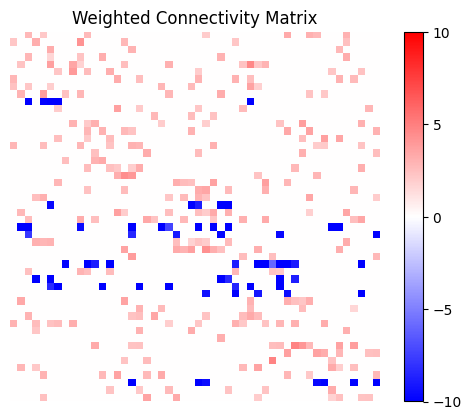

In [49]:
# Visualize weighted connectivity matrix
fig, ax = plt.subplots()
im = ax.imshow(weights, cmap="bwr", vmin=-10, vmax=10)
cbar = plt.colorbar(im, ax=ax, ticks=[-10, -5, 0, 5, 10])
ax.set_title("Weighted Connectivity Matrix")
ax.axis("off")
plt.show()

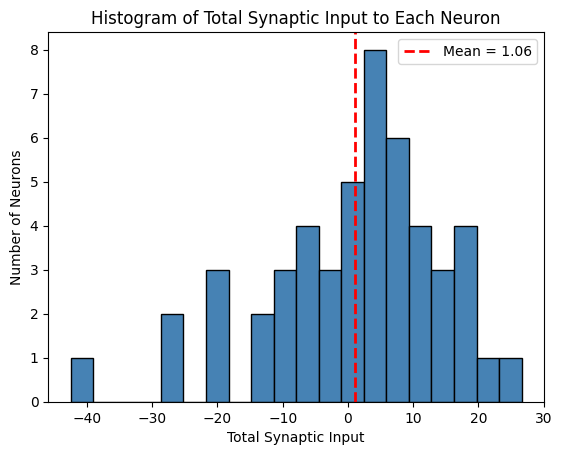

In [50]:
# Plot histogram of total synaptic input to each neuron
synaptic_inputs = weights.sum(axis=0)
mean_input = synaptic_inputs.mean()

fig, ax = plt.subplots()
ax.hist(synaptic_inputs, bins=20, color="steelblue", edgecolor="black")
ax.axvline(mean_input, color="red", linestyle="--", linewidth=2, label=f"Mean = {mean_input:.2f}")
ax.set_title("Histogram of Total Synaptic Input to Each Neuron")
ax.set_xlabel("Total Synaptic Input")
ax.set_ylabel("Number of Neurons")
ax.legend()
plt.show()

### Create network inputs

To run our network simulation, we additionally need to define feedforward inputs into the network.

To simulate baseline activity in the zebrafish olfactory bulb (OB), we simulate a population of mitral cells firing with Poisson statistics. These cells then project randomly with sparse connectivity to excitatory cells in our Dp network, with weights generated from a log-normal distribution.

We also decide at this point to simulate the network activity for 10s.

In [51]:
# Display feedforward input parameters
feedforward_symbols = ['num_mitral', 'r_mitral', 'p_feedforward', 'w_mu_FF', 'w_sigma_FF']
feedforward_params = params_df[params_df['symbol'].isin(feedforward_symbols)]

print("Feedforward Input Parameters")
print("=" * 62)
display(feedforward_params.style.set_properties(**{'text-align': 'left'}).set_table_styles([
    {'selector': 'th', 'props': [('text-align', 'left')]}
]).hide(axis='index').format({'value': '{:.2f}'}))

Feedforward Input Parameters


symbol,unit,description,value
num_mitral,nan,Number of mitral cells (feedforward inputs),100.00
r_mitral,Hz,Firing rate of mitral cells (Poisson),6.00
p_feedforward,nan,Connection probability from mitral cells to Dp,0.10
w_mu_FF,voxel,Mean (log-space) for feedforward synaptic weights,0.00
w_sigma_FF,voxel,Standard deviation (log-space) for feedforward weights,0.20


In [52]:
# Generate Poisson spike trains for mitral cells
n_steps = int(duration / delta_t)
shape = (1, n_steps, num_mitral)
p_spike = r_mitral * delta_t * 1e-3 # rate in Hz, delta_t in ms
input_spikes = np.random.rand(*shape) < p_spike

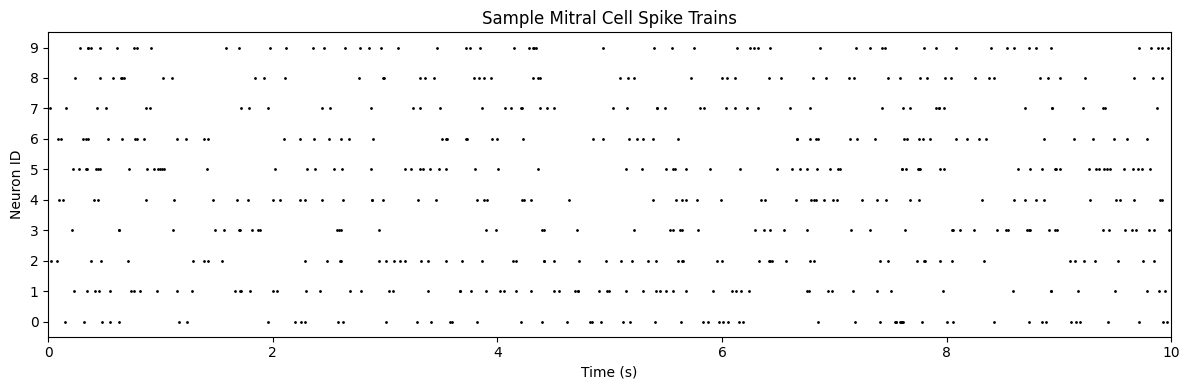

In [53]:
# Visualize sample mitral cell spike trains
fig, ax = plt.subplots(figsize=(12, 4))
spike_times, neuron_ids = np.where(input_spikes[0, :, :10])
ax.scatter(spike_times * delta_t * 1e-3, neuron_ids, s=1, color='black')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Neuron ID')
ax.set_title('Sample Mitral Cell Spike Trains')
ax.set_ylim(-0.5, 9.5)
ax.set_yticks(range(10))
ax.set_xlim(0, duration*1e-3)
plt.tight_layout()
plt.show()

In [54]:
# Generate feedforward connectivity graph and mask inhibitory targets
feedforward_connectivity_graph, _ = topology_generators.sparse_graph_generator(
    num_neurons=(num_mitral, num_neurons),
    p=p_feedforward,
    p_E=1.0,
)
# Set connections to inhibitory cells to zero (only connect to excitatory cells)
inhibitory_cells = np.where(neuron_types == -1)[0]
feedforward_connectivity_graph[:, inhibitory_cells] = 0

In [55]:
# Assign log-normal weights to feedforward connectivity and scale
feedforward_weights = weight_assigners.assign_weights_lognormal(
    connectivity_graph=feedforward_connectivity_graph,
    neuron_types=np.ones(num_mitral),
    w_mu_E=w_mu_FF,
    w_sigma_E=w_sigma_FF,
    w_mu_I=w_mu_I,
    w_sigma_I=w_sigma_I,
)

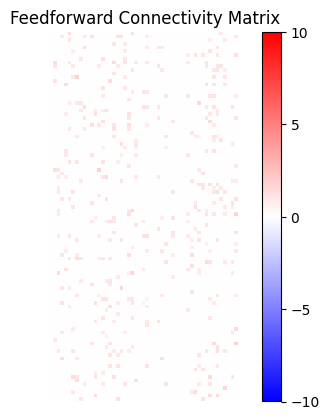

In [56]:
# Visualize feedforward connectivity matrix
fig, ax = plt.subplots()
im = ax.imshow(feedforward_weights, cmap="bwr", vmin=-10, vmax=10)
cbar = plt.colorbar(im, ax=ax, ticks=[-10, -5, 0, 5, 10])
ax.set_title("Feedforward Connectivity Matrix")
ax.axis("off")
plt.show()

### Neuron Physiology Parameters

Before we can simulate a recurrent SNN with this weight matrix, we review the neuron physiology parameters.

These parameters are adapted from [Meissner-Bernard et al. (2025)](https://doi.org/10.1016/j.celrep.2025.115330), which includes a combination of parameters measured in zebrafish Dp and some fit to match experimental network activity recordings in this network.

In [57]:
# Display neuron physiology parameters
physiology_symbols = ['tau_mem_E', 'tau_mem_I', 'tau_syn_E', 'tau_syn_I', 
                      'R_E', 'R_I', 'U_rest_E', 'U_rest_I',
                      'theta_E', 'theta_I', 'U_reset_E', 'U_reset_I',
                      'tau_ref_E', 'tau_ref_I']
physiology_params = params_df[params_df['symbol'].isin(physiology_symbols)]

print("Neuron Physiology Parameters (adapted from Meissner-Bernard et al. 2025)")
print("=" * 62)
display(physiology_params.style.set_properties(**{'text-align': 'left'}).set_table_styles([
    {'selector': 'th', 'props': [('text-align', 'left')]}
]).hide(axis='index').format({'value': '{:.2f}'}))

Neuron Physiology Parameters (adapted from Meissner-Bernard et al. 2025)


symbol,unit,description,value
tau_mem_E,ms,Membrane time constant for excitatory neurons,85.00
tau_syn_E,ms,Synaptic time constant for excitatory connections,30.00
R_E,MOhm,Membrane resistance for excitatory neurons,740.74
U_rest_E,mV,Resting membrane potential for excitatory neurons,-60.00
theta_E,mV,Spike threshold voltage for excitatory neurons,-38.00
U_reset_E,mV,Reset voltage after spike for excitatory neurons,-60.00
tau_ref_E,ms,Refractory period for excitatory neurons,8.00
tau_mem_I,ms,Membrane time constant for inhibitory neurons,50.00
tau_syn_I,ms,Synaptic time constant for inhibitory connections,10.00
R_I,MOhm,Membrane resistance for inhibitory neurons,1111.11


### Initialise network and run simulation

Here we finally initialise our current-based LIF recurrent network with the connectivity and inputs we have created. We simulate it for 10s and plot a sample of some of the spike trains it produces.

In [58]:
# Initialize LIF network model and run simulation
model = CurrentLIFNetwork(
    csv_path=repo_root / "parameters" / "network-default.csv",
    neuron_types=neuron_types,
    recurrent_weights=weights,
    feedforward_weights=feedforward_weights*scaling_factor_FF,
)

model.initialise_parameters(
    E_weight=scaling_factor_E,
    I_weight=scaling_factor_I,
)

output_spikes, output_voltages, output_currents = model.forward(
    n_steps=n_steps,
    inputs=input_spikes,
)

FileNotFoundError: [Errno 2] No such file or directory: '/home/bedfrory/Documents/connectome-snns/parameters/network-default.csv'

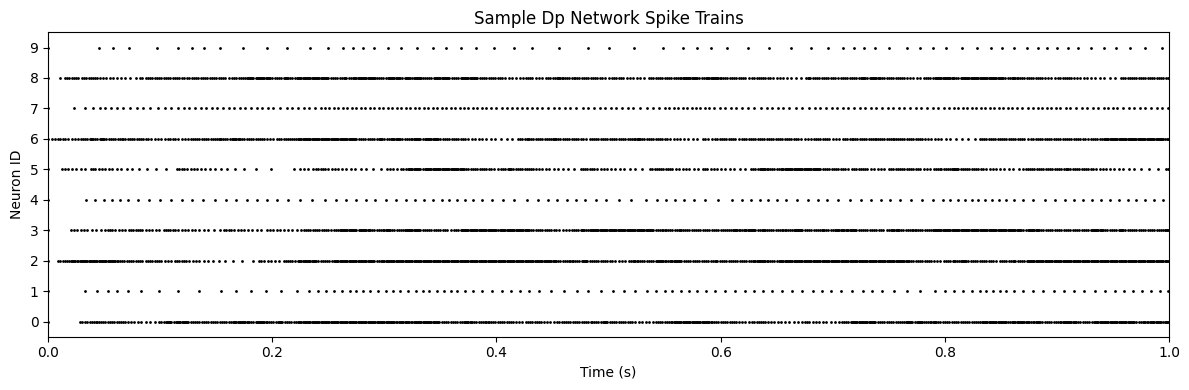

In [ ]:
# Visualize sample Dp network spike trains
fig, ax = plt.subplots(figsize=(12, 4))
time_window = int(1.0 / dt)
spike_times, neuron_ids = np.where(output_spikes[0, :time_window, :])
ax.scatter(spike_times * dt, neuron_ids, s=1, color='black')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Neuron ID')
ax.set_title('Sample Dp Network Spike Trains')
ax.set_ylim(-0.5, 9.5)
ax.set_yticks(range(10))
ax.set_xlim(0, 1.0)
plt.tight_layout()
plt.show()

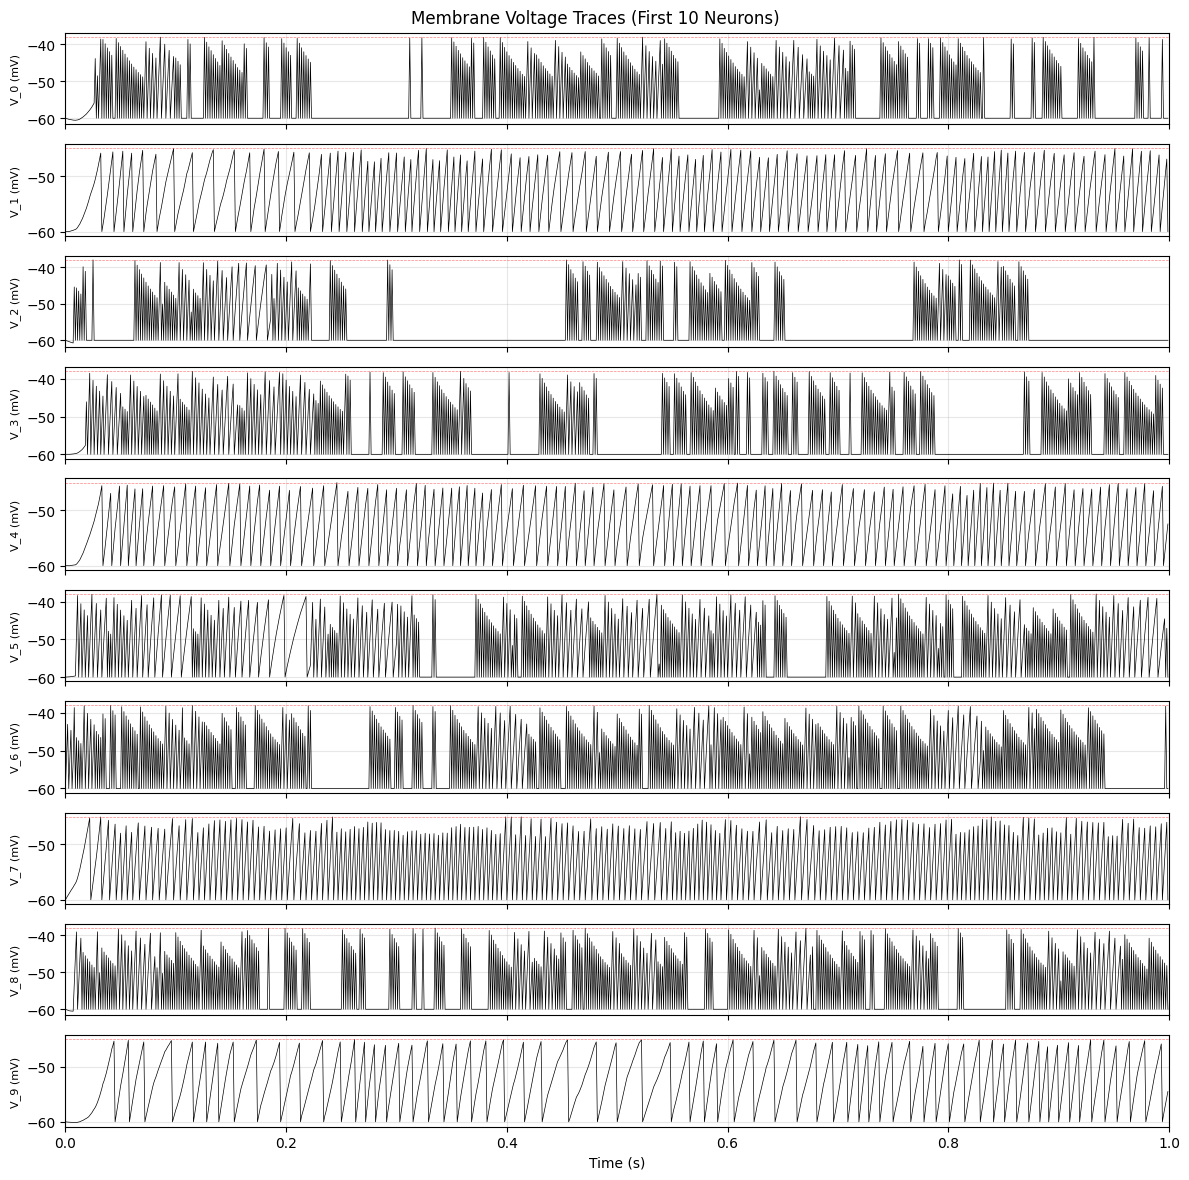

In [ ]:
# Visualize membrane voltages for the first 10 neurons
fig, axes = plt.subplots(10, 1, figsize=(12, 12), sharex=True)
time_axis = np.arange(time_window) * dt

for neuron_id in range(10):
    axes[neuron_id].plot(time_axis, output_voltages[0, :time_window, neuron_id].detach().cpu().numpy(), 
                         linewidth=0.5, color='black')
    axes[neuron_id].set_ylabel(f'V_{neuron_id} (mV)', fontsize=8)
    axes[neuron_id].set_xlim(0, 1.0)
    axes[neuron_id].grid(True, alpha=0.3)
    
    # Add threshold line if available
    if neuron_types[neuron_id] == 1:
        axes[neuron_id].axhline(y=model.theta_exc.item(), color='red', linestyle='--', linewidth=0.5, alpha=0.5)
    else:
        axes[neuron_id].axhline(y=model.theta_inh.item(), color='red', linestyle='--', linewidth=0.5, alpha=0.5)

axes[-1].set_xlabel('Time (s)')
fig.suptitle('Membrane Voltage Traces (First 10 Neurons)', fontsize=12)
plt.tight_layout()
plt.show()